### Imports

In [1]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sklearn
# import fastai
# from fastai.vision.all import *
import time
from PIL import Image
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from torchvision import transforms
from dataset import BiomassDataset
import torch.nn as nn
import timm
from torchvision import models
from model import MultiTaskModel
from utils import print_result


In [2]:
kaggle_path = './kaggle/input/csiro-biomass/train.csv'
local_path = '/Users/guytabennett-jones/code/me/ai/kaggle/biomass/input/train.csv'
vast_path = '/workspace/biomass/input/train.csv'
dataset_df = pd.read_csv(vast_path)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (1785, 9)


In [3]:
dataset_df = dataset_df.pivot(
    index='image_path',
    columns='target_name',
    values='target'
).reset_index()

### Pytorch

In [4]:
local_path = '/Users/guytabennett-jones/code/me/ai/kaggle/biomass/input/'
kaggle_path = '/kaggle/input/csiro-biomass/'
vast_path = '/workspace/biomass/input/'

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((576, 576)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiTaskModel().to(device)

### Feature Engineering

### Create datasets

In [6]:
kaggle_path = '/kaggle/input/csiro-biomass/'
local_path =  '/Users/guytabennett-jones/code/me/ai/kaggle/biomass/input/'
vast_path = '/workspace/biomass/input/'

### Support Functions

In [7]:
# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 8
NUM_EPOCHS = 10
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 1e-7
NUM_FOLDS = 4

In [8]:
def forward_pass(images, targets, validation=False):
    images = images.to(device)
    targets = targets.to(device)
    
    if not validation: 
        optimizer.zero_grad()
    
    outputs = model(images)
    
    loss = combined_biomass_loss(outputs, targets)
    
    if not validation:
        loss.backward()
        optimizer.step()
    
    return loss


### Learning rate

In [9]:
# print(train_df[['Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g', 'GDM_g']].describe())

In [10]:
def find_lr(model, train_loader, optimizer, device, start_lr=1e-8, end_lr=1, num_iter=100):
    model.train()
    lr_mult = (end_lr / start_lr) ** (1 / num_iter)
    lr = start_lr
    
    lrs, losses = [], []
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    for i, (images, targets) in enumerate(train_loader):
        if i >= num_iter:
            break
        
        total_loss = forward_pass(images, targets)
        if i == 0:
            with torch.no_grad():
                outputs = model(images.to(device))
                print("Sample predictions:", outputs[0])
                print("Sample targets:", targets[0].to(device))
            
        lrs.append(lr)
        losses.append(total_loss.item())        
        
        lr *= lr_mult
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    
    # Plot
    plt.figure()
    plt.plot(lrs, losses)
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.title('Learning Rate Finder')
    plt.show()
    
    return lrs, losses

### Train Model

In [11]:
def combined_biomass_loss(biomass_pred, biomass_true):
    weights = torch.tensor([0.1, 0.1, 0.1, 0.5, 0.2], device=biomass_pred.device)
    
    smooth_l1 = nn.SmoothL1Loss(reduction='none')
    mse = nn.MSELoss(reduction='none')
    
    smooth_l1_loss = smooth_l1(biomass_pred, biomass_true)
    mse_loss = mse(biomass_pred, biomass_true)
    
    # Combine: 50% SmoothL1, 50% MSE
    combined = 0.5 * smooth_l1_loss + 0.5 * mse_loss
    weighted_loss = (combined * weights).mean()
    
    return weighted_loss

In [12]:
def weighted_r2_score(preds, targets):
    weights = torch.tensor([0.1, 0.1, 0.1, 0.5, 0.2], device=preds.device)
    # Order: Dry_Clover_g, Dry_Dead_g, Dry_Green_g, Dry_Total_g, GDM_g
    
    # Flatten to treat all samples together
    preds_flat = preds.reshape(-1, 5)
    targets_flat = targets.reshape(-1, 5)
    
    # Compute weighted mean
    w_expanded = weights.unsqueeze(0).expand_as(targets_flat)
    weighted_mean = (targets_flat * w_expanded).sum() / w_expanded.sum()
    
    # SS_res and SS_tot
    ss_res = ((targets_flat - preds_flat) ** 2 * w_expanded).sum()
    ss_tot = ((targets_flat - weighted_mean) ** 2 * w_expanded).sum()
    
    r2 = 1 - (ss_res / ss_tot)
    return r2.item()

In [13]:
dataset_df.head()

target_name,image_path,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g
0,train/ID1011485656.jpg,0.0000,31.9984,16.2751,48.2735,16.2750
1,train/ID1012260530.jpg,0.0000,0.0000,7.6000,7.6000,7.6000
2,train/ID1025234388.jpg,6.0500,0.0000,0.0000,6.0500,6.0500
3,train/ID1028611175.jpg,0.0000,30.9703,24.2376,55.2079,24.2376
4,train/ID1035947949.jpg,0.4343,23.2239,10.5261,34.1844,10.9605


In [14]:
# k-fold
from sklearn.model_selection import KFold

kfold = KFold(n_splits=4, shuffle=True, random_state=4)
splits = kfold.split(dataset_df)


In [15]:
# Run LR finder on first fold to find optimal learning rate
# train_idx, val_idx = list(splits)[0]
# train_df = dataset_df.iloc[train_idx].copy()

# train_dataset = BiomassDataset(train_df, vast_path, transform=train_transform)
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [16]:
def create_data_loaders(train_df, val_df, batch_size=BATCH_SIZE):
    train_dataset = BiomassDataset(train_df, vast_path, transform=train_transform)
    val_dataset = BiomassDataset(val_df, vast_path, transform=val_transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    return train_loader, val_loader

def train_epoch(model, train_loader):
    model.train()
    total_loss = 0
    for images, targets in train_loader:
        loss = forward_pass(images, targets)
        total_loss += loss
    return total_loss

def validate_epoch(model, val_loader):
    model.eval()
    all_preds, all_targets = [], []
    total_loss = 0
    
    with torch.no_grad():
        for images, targets in val_loader:
            images = images.to(device)
            targets = targets.to(device)
            
            outputs = model(images)
            loss = combined_biomass_loss(outputs, targets)
            
            total_loss += loss.item()
            all_preds.append(outputs.cpu())
            all_targets.append(targets.cpu())
    
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    r2 = weighted_r2_score(all_preds, all_targets)
    
    return total_loss / len(val_loader), r2


splits = kfold.split(dataset_df)  # Recreate the generator
for fold, (train_idx, val_idx) in enumerate(splits):
    if fold + 1 > 1:
        break
    print(f'\n--- Fold {fold + 1}/{NUM_FOLDS} ---')
    
    # Prepare data with standardization
    train_df = dataset_df.iloc[train_idx].copy()
    val_df = dataset_df.iloc[val_idx].copy()
    
    # scaler = StandardScaler()
    # train_df[target_cols] = scaler.fit_transform(train_df[target_cols])
    # val_df[target_cols] = scaler.transform(val_df[target_cols])
    
    train_loader, val_loader = create_data_loaders(train_df, val_df)
    
    # Initialize model
    model = MultiTaskModel().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    
    # Training loop
    for epoch in range(NUM_EPOCHS):
        epoch_start = time.time()
        
        train_loss = train_epoch(model, train_loader)
        val_loss, val_r2 = validate_epoch(model, val_loader)
        
        print_result(train_loss, val_loss, epoch_start, epoch, NUM_EPOCHS, val_r2)

    
    print(f'Fold {fold + 1} complete!')



--- Fold 1/4 ---
Epoch 1/10 - Train Loss: 7587.3447, Val Loss: 60.2394 | R²: 0.2082 | Time: 0m 22s
Epoch 2/10 - Train Loss: 2678.1584, Val Loss: 70.6510 | R²: 0.0666 | Time: 0m 21s
Epoch 3/10 - Train Loss: 2102.8306, Val Loss: 91.8186 | R²: -0.2264 | Time: 0m 21s
Epoch 4/10 - Train Loss: 2054.0129, Val Loss: 86.4880 | R²: -0.1470 | Time: 0m 21s
Epoch 5/10 - Train Loss: 1946.5284, Val Loss: 57.8034 | R²: 0.2445 | Time: 0m 21s
Epoch 6/10 - Train Loss: 1677.6757, Val Loss: 49.2681 | R²: 0.3487 | Time: 0m 21s
Epoch 7/10 - Train Loss: 1424.7103, Val Loss: 83.0870 | R²: -0.1053 | Time: 0m 21s
Epoch 8/10 - Train Loss: 1134.1724, Val Loss: 78.8333 | R²: -0.0466 | Time: 0m 21s
Epoch 9/10 - Train Loss: 1625.0699, Val Loss: 126.5768 | R²: -0.6851 | Time: 0m 21s
Epoch 10/10 - Train Loss: 1395.5526, Val Loss: 108.8610 | R²: -0.4458 | Time: 0m 21s
Fold 1 complete!


Sample predictions: tensor([ 5.4231, 16.3827, 23.9178, 42.3864, 25.0142], device='cuda:0')
Sample targets: tensor([ 0., 26., 23., 49., 23.], device='cuda:0')


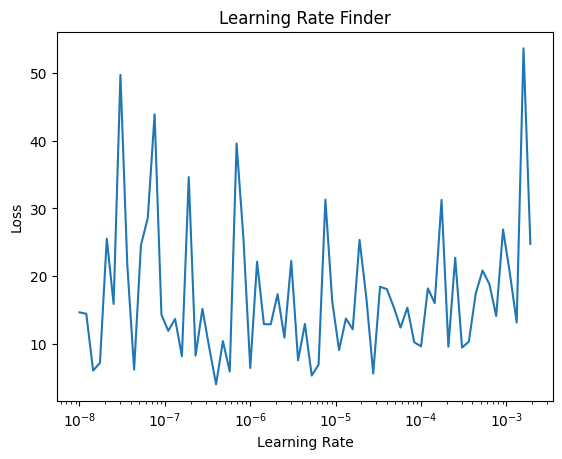

In [17]:
lrs, losses = find_lr(model, train_loader, optimizer, device)


resnet50 322
With aug Val Loss: 404.3574  
Epoch 10 / 10  →  Train Loss: 404.0312   |   Val Loss: 526.2535  

✅ Training complete!  
Final batch loss: **730.4459**

In [18]:
df = pd.DataFrame({
    'lrs': lrs,
    'losses': losses
})
df.describe()

,lrs,losses
count,6.700000e+01,67.000000
mean,1.690456e-04,17.243977
std,3.866555e-04,10.342517
min,1.000000e-08,4.043297
25%,2.098164e-07,9.946449
50%,4.365158e-06,14.666389
75%,9.158819e-05,21.945217
max,1.905461e-03,53.623116


In [19]:
# Get the predictions for testdata
with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds.extend(outputs.cpu().numpy())
predictions = np.array(preds).flatten()

NameError: name 'test_loader' is not defined

In [ ]:
val_df.head()
train_df.shape

In [ ]:
# Submit
sample_submission_df = pd.read_csv('/kaggle/input/csiro-biomass/sample_submission.csv')
sample_submission_df['target'] = predictions
sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission_df.head()